三种可视化的方法。  

1. 可视化卷积神经网络的中间输出（中间激活）：有助于理解卷积神经网络连续的层如何对输入进行变换，也有助于初步了解卷积神经网络每个过滤器的含义。
2. 可视化卷积神经网络的过滤器：有助于精确理解卷积神经网络中每个过滤器容易接受的视觉模式或视觉概念。
3. 可视化图像中类激活的热力图：有助于理解图像的哪个部分被识别为属于某个类别，从而可以定位图像中的物体。

### 5.4.1　可视化中间激活
可视化中间激活，是指对于给定输入，展示网络中各个卷积层和池化层输出的特征图（层的输出通常被称为该层的激活，即激活函数的输出）。这让我们可以看到输入如何被分解为网络学到的不同过滤器。我们希望在三个维度对特征图进行可视化：宽度、高度和深度（通道）。每个通道都对应相对独立的特征，所以将这些特征图可视化的正确方法是将每个通道的内容分别绘制成二维图像。我们首先来加载 5.2节保存的模型。

In [1]:
import os, shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

In [9]:
model=load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [10]:
# 接下来，我们需要一张输入图像

img_path= 'cats_and_dogs_small/test/cats/cat.1700.jpg'
img= image.load_img(img_path,target_size=(150,150)) 
img_tensor=image.img_to_array(img) # 将图片转换成数字张量 150 * 150 *3

img_tensor=np.expand_dims(img_tensor,axis=0) # 1* 150 * 150 *3
img_tensor /= 255  # 因为高逼格的sensor中ADC是10BIT或16BIT，那么图像像素灰度值的变化范围就是0 - 1024 或 0 - 65536。
                   #只是常见的灰度图像像素灰度值变化范围是0 - 255，还有更高的。
                   #二值化后的图像只有0和1，简单的说只有黑和白。
        
print(img_tensor.shape) 

(1, 150, 150, 3)


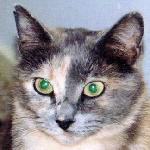

In [11]:
img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


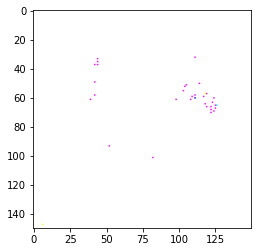

In [19]:
plt.imshow(img_tensor[0])
plt.show()

为了提取想要查看的特征图，我们需要创建一个 Keras模型，以图像批量作为输入，并输出所有卷积层和池化层的激活。为此，我们需要使用  Keras的Model类。模型实例化需要两个参数：一个输入张量（或输入张量的列表）和一个输出张量（或输出张量的列表）。得到的类是一个Keras模型，就像你熟悉的Sequential模型一样，将特定输入映射为特定输出。Model类允许模型有多个输出，这一点与Sequential模型不同。想了解Model类的更多信息，请参见    7.1节。

In [11]:
# 用一个输入张量和一个输出张量列表将模型实例化
layer_outputs=[layer.output for layer in model.layers[:8]] # 提取前8层的输出
activation_model = models.Model(inputs= model.input, outputs= layer_outputs) # 给定模型输入，可以返回这些输出值。

# 输入一张图像，这个模型将返回原始模型前  8层的激活值。这是你在本书中第一次遇到的多输出模型，
# 之前的模型都是只有一个输入和一个输出。一般情况下，模型可以有任意个输入和输出。
# 这个模型有一个输入和 8个输出，即每层激活对应一个输出。

In [12]:
activation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8_input (InputLayer)  [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0     

In [13]:
# 返回8个numpy数组组成的列表，每层激活对应一个numpy数组
activations = activation_model.predict(img_tensor) 

In [15]:
first_layer_activation= activations[0]
print(first_layer_activation.shape) # 它是一个148* 148的特征图，有32个通道

(1, 148, 148, 32)


In [16]:
first_layer_activation

array([[[[0.04293103, 0.        , 0.        , ..., 0.08412698,
          0.        , 0.03633105],
         [0.0494023 , 0.        , 0.        , ..., 0.09019361,
          0.        , 0.03143963],
         [0.04589615, 0.        , 0.        , ..., 0.08809326,
          0.        , 0.03253124],
         ...,
         [0.06753106, 0.        , 0.        , ..., 0.12443569,
          0.        , 0.03493719],
         [0.0660364 , 0.        , 0.        , ..., 0.12602113,
          0.        , 0.03233922],
         [0.06405544, 0.        , 0.        , ..., 0.12441635,
          0.        , 0.03659593]],

        [[0.04270377, 0.        , 0.        , ..., 0.07957722,
          0.        , 0.03566606],
         [0.04830648, 0.        , 0.        , ..., 0.08449885,
          0.        , 0.02877476],
         [0.0502379 , 0.        , 0.        , ..., 0.0941317 ,
          0.        , 0.03367946],
         ...,
         [0.0655166 , 0.        , 0.        , ..., 0.1259603 ,
          0.        , 0.0

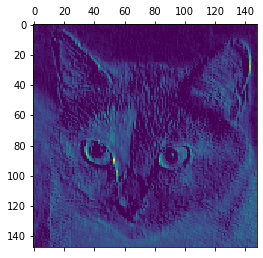

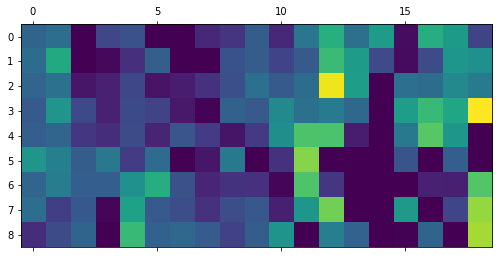

In [38]:
#我们来绘制原始模型第一层激活的第4个通道（见图 5-25）。

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.matshow(first_layer_activation[0, 1:10, 1:20, 4], cmap='viridis') # 取不同的维度

下面我们来绘制网络中所有激活的完整可视化（见图 5-27）。我们需要在 8个特征图中的每一个中提取并绘制每一个通道，然后将结果叠加在一个大的图像张量中，按通道并排。



<ipython-input-18-5240d1e77614>:17: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


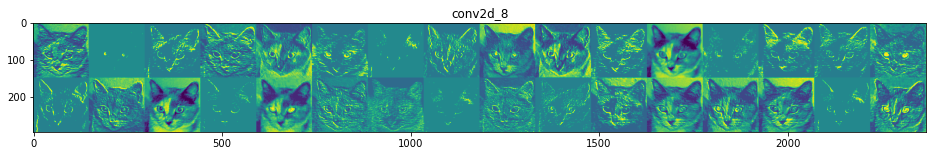

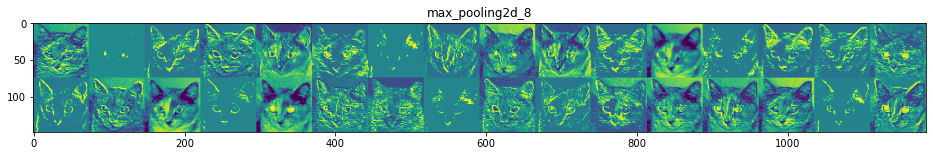

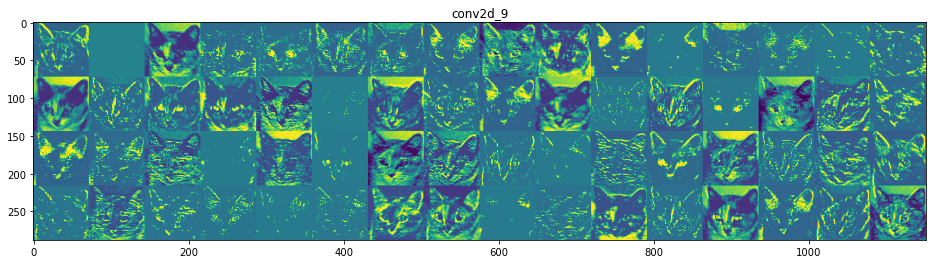

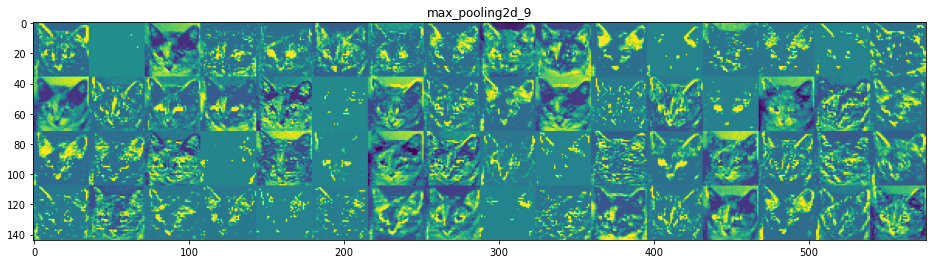

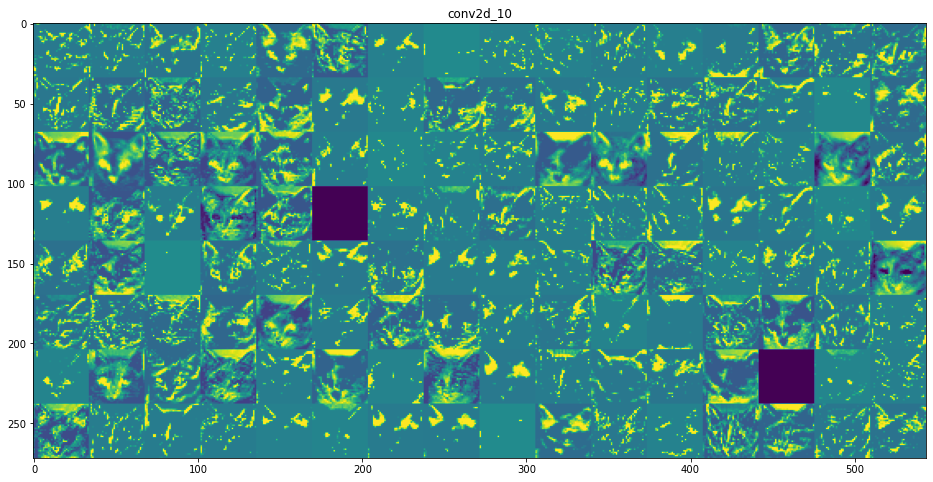

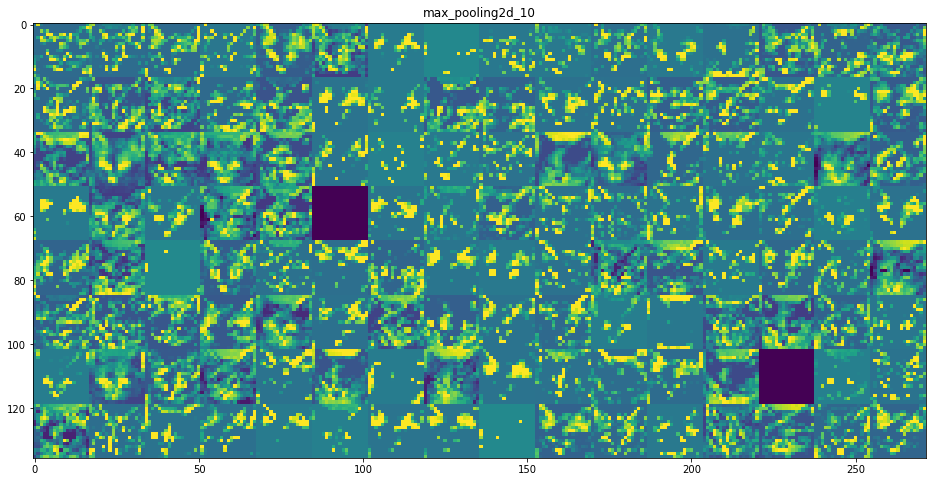

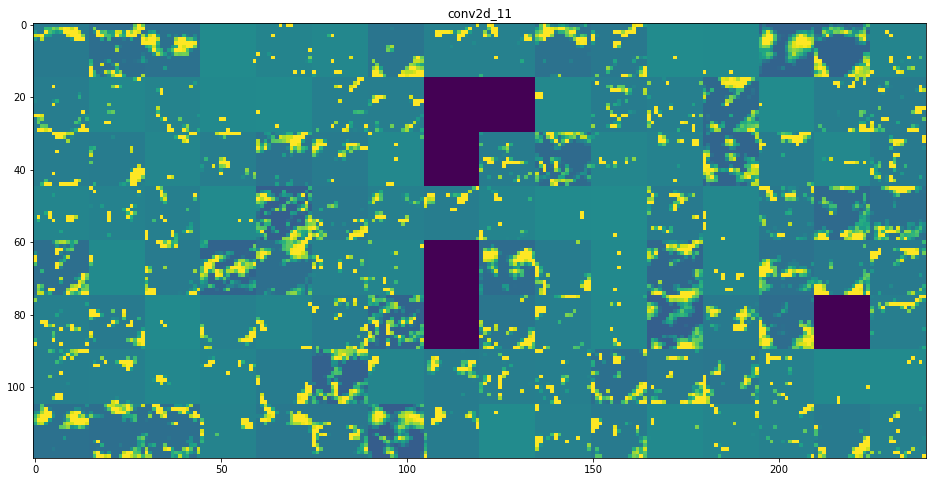

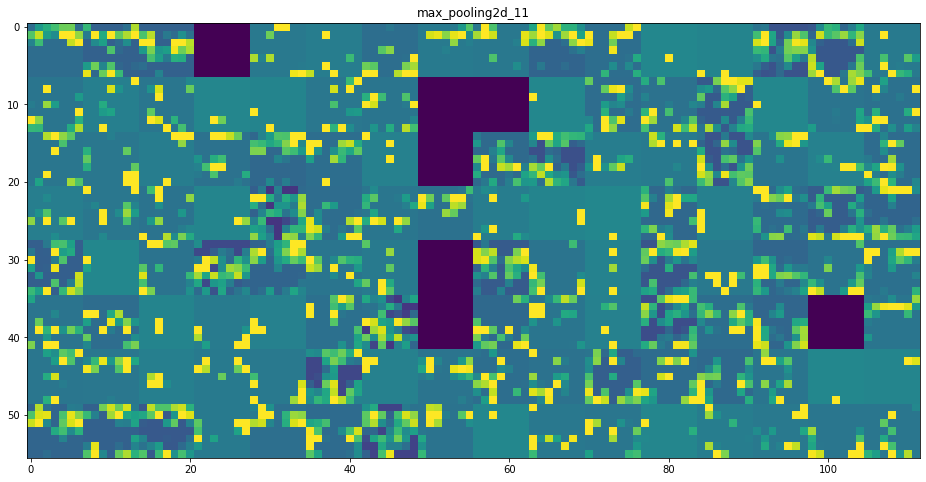

In [18]:
layer_names=[]
for layer in model.layers[:8]: # 层的名称，这样你可以将这些名称画到图中
    layer_names.append(layer.name)

images_per_row=16

for layer_name, layer_activation in zip(layer_names, activations): # 显示特征图 zip 是将两个list中，用一个position的element合并到一起
    n_features = layer_activation.shape[-1] # 特征图中的特征个数,因为shape里包含了inpute那层layer
    size= layer_activation.shape[1] # 特征图的形状为(1,size,size,n_features)
    n_cols=n_features // images_per_row #在这个矩阵中将激活通道平铺
    display_grid= np.zeros((size * n_cols, images_per_row * size)) 
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                            :,:,col * images_per_row+ row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *=64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col *size : (col+1) *size,
                         row * size : (row+1) * size]=channel_image
    scale = 1./size
    plt.figure(figsize= (scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
            
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect= 'auto', cmap= 'viridis')
            
     

In [19]:
layer_names

['conv2d_8',
 'max_pooling2d_8',
 'conv2d_9',
 'max_pooling2d_9',
 'conv2d_10',
 'max_pooling2d_10',
 'conv2d_11',
 'max_pooling2d_11']

In [63]:
x = [1, 2, 3]
y = [4, 5, 6]

for i, j in zip(x, y):
   print(str(i) + " / " + str(j))

1 / 4
2 / 5
3 / 6


In [62]:
a = ("John", "Charles", "Mike")
b = ("Jenny", "Christy", "Monica")

x = zip(a, b)
print(tuple(x))

(('John', 'Jenny'), ('Charles', 'Christy'), ('Mike', 'Monica'))


这里需要注意以下几点。

第一层是各种边缘探测器的集合。在这一阶段，激活几乎保留了原始图像中的所有信息。
随着层数的加深，激活变得越来越抽象，并且越来越难以直观地理解。它们开始表示更高层次的概念，比如“猫耳朵”和“猫眼睛”。层数越深，其表示中关于图像视觉内容的信息就越少，而关于类别的信息就越多。
激活的稀疏度（sparsity）随着层数的加深而增大。在第一层里，所有过滤器都被输入图像激活，但在后面的层里，越来越多的过滤器是空白的。也就是说，输入图像中找不到这些过滤器所编码的模式。

我们刚刚揭示了深度神经网络学到的表示的一个重要普遍特征：随着层数的加深，层所提取的特征变得越来越抽象。更高的层激活包含关于特定输入的信息越来越少，而关于目标的信息越来越多（本例中即图像的类别：猫或狗）。深度神经网络可以有效地作为信息蒸馏管道（information distillation  pipeline），输入原始数据（本例中是 RGB图像），反复对其进行变换，将无关信息过滤掉（比如图像的具体外观），并放大和细化有用的信息（比如图像的类别）。

### 5.4.2　可视化卷积神经网络的过滤器
想要观察卷积神经网络学到的过滤器，另一种简单的方法是显示每个过滤器所响应的视觉模式。这可以通过在输入空间中进行梯度上升来实现：从空白输入图像开始，将梯度下降应用于卷积神经网络输入图像的值，其目的是让某个过滤器的响应最大化。得到的输入图像是选定过滤器具有最大响应的图像。

这个过程很简单：我们需要构建一个损失函数，其目的是让某个卷积层的某个过滤器的值最大化；然后，我们要使用随机梯度下降来调节输入图像的值，以便让这个激活值最大化。例如，对于在ImageNet上预训练的VGG16网络，其block3_conv1层第0个过滤器激活的损失如下所示。

In [20]:
model = VGG16(weights='imagenet',
              include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

为了实现梯度下降，我们需要得到损失相对于模型输入的梯度。为此，我们需要使用  Keras的backend模块内置的gradients 函数。

In [26]:
# 获取损失相对于输入的梯度
import tensorflow as tf

tf.compat.v1.disable_eager_execution()


model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

grads=K.gradients(loss, model.input)[0] # 调用gradients 返回的是一个张量列表(本例中列表长度为1)，因此，只保留第一个元素。

为了让梯度下降过程顺利进行，一个非显而易见的技巧是将梯度张量除以其 L2范数（张量中所有值的平方的平均值的平方根）来标准化。这就确保了输入图像的更新大小始终位于相同的范围。

In [27]:
grads /= (K.sqrt(K.mean(K.square(grads)))+ 1e-5)   # 做除法前加上1e-5，防止除以0


现在你需要一种方法：给定输入图像，它能够计算损失张量和梯度张量的值。你可以定义一个 Keras后端函数来实现此方法：iterate是一个函数，它将一个   Numpy张量（表示为长度为 1的张量列表）转换为两个 Numpy张量组成的列表，这两个张量分别是损失值和梯度值。

In [28]:
iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [29]:
# 通过随机梯度下降让损失最大化

input_img_data=np.random.random((1,150,150,3)) *20 +128 # 从一张有噪声的灰度图像开始

step =1 # 每次梯度更新的步长
for i in range(40):
    loss_value, grads_value =iterate([input_img_data])
    input_img_data += grads_value * step # 沿着让损失最大化的方向调节输入图像

得到的图像张量是形状为(1,  150, 150, 3)的浮点数张量，其取值可能不是  [0, 255]区间内的整数。因此，你需要对这个张量进行后处理，将其转换为可显示的图像。下面这个简单的实用函数可以做到这一点

In [30]:
# 将张量转换为有效图像的实用函数
def deprocess_image(x):
    x -= x.mean() # 对张量做标准化，使其均值为0
    x /= (x.std()+ 1e-5) # 使其标准差为0.1
    x *= 0.1
    
    x += 0.5   # 将 x 裁切到【0，1】区间
    x =np.clip(x,0,1)
    
    x*= 255 #将 x 转换为 RGB 数组
    x = np.clip(x,0,255).astype('uint8')
    return x


上述代码片段放到一个Python函数中，输入一个层的名称和一个过滤器索引，它将返回一个有效的图像张量，表示能够将特定过滤器的激活最大化的模式。

In [31]:
# 生成过滤器可视化的函数
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss=K.mean(layer_output[:,:,:,filter_index])
    
    grads= K.gradients(loss, model.input)[0]   # 计算这个损失相对于输入图像的梯度
    
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5) #标准化技巧
    
    iterate = K.function([model.input], [loss, grads])  # 返回给定输入图像的损失和梯度
     
    input_img_data =np.random.random((1,size,size,3))* 20 +128. # 从带有噪声的灰度图像开始
    
    step=1
    for i in range(40):
        loss_value, grads_value= iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    
    return deprocess_image(img)

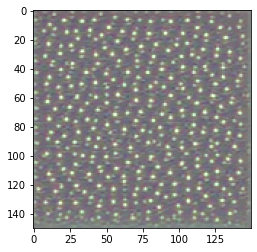

In [32]:
plt.imshow(generate_pattern('block3_conv1',0))

看起来，block3_conv1层第   0个过滤器响应的是波尔卡点（     polka-dot）图案。下面来看有趣的部分：我们可以将每一层的每个过滤器都可视化。为了简单起见，我们只查看每一层的前  64个过滤器，并只查看每个卷积块的第一层（即   block1_conv1、block2_conv1、block3_conv1、block4_ conv1、block5_conv1）。我们将输出放在一个  8×8的网格中，每个网格是一个   64像素×  64像素的过滤器模式，两个过滤器模式之间留有一些黑边（见图 5-30 ~图  5-33

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


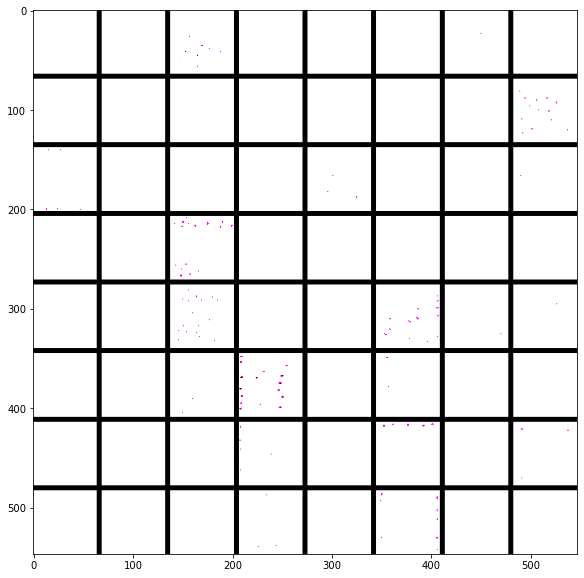

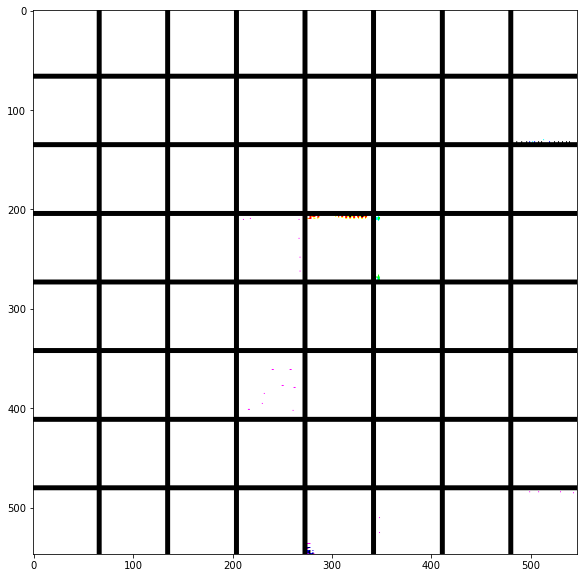

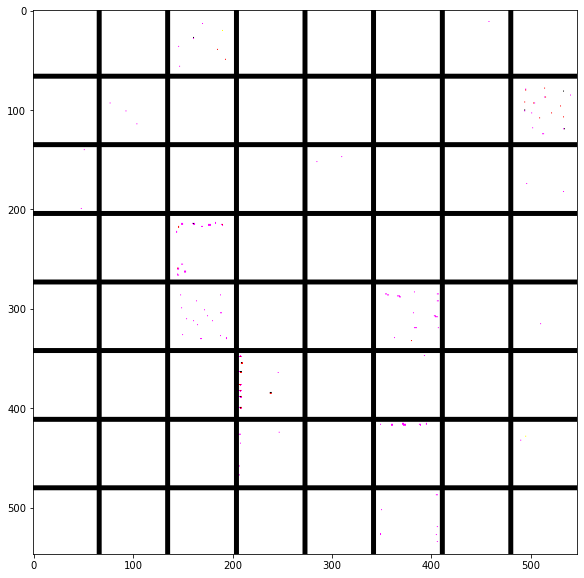

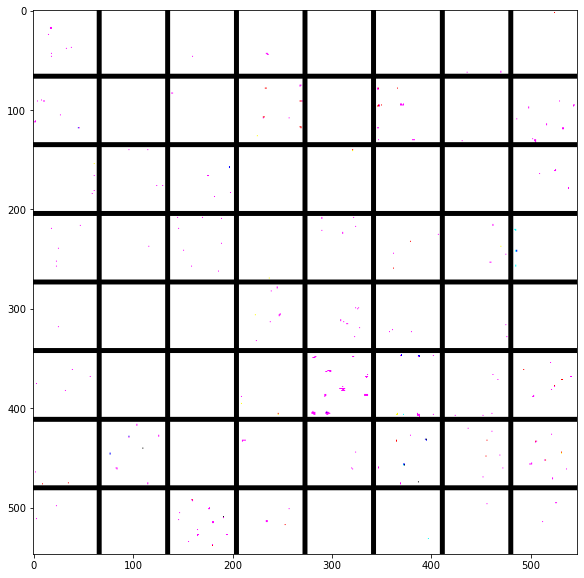

In [97]:
layer_name= 'block3_conv1'
size= 64
margin = 5
results =np.zeros((8 * size + 7* margin, 8*size+ 7*margin,3)) # 空图像用于保存结果

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i+ (j * 8),size = size)
        
        horizontal_start = i *size +i * margin
        horizontal_end= horizontal_start+size
        vertical_start = j *size + j* margin
        vertical_end = vertical_start +size
        results[horizontal_start: horizontal_end,
               vertical_start: vertical_end, :]=filter_img

plt.figure(figsize= (10,10))
plt.imshow(results)
plt.imsave('image_new1.pdf',results)

layer_name= 'block2_conv1'
size= 64
margin = 5
results =np.zeros((8 * size + 7* margin, 8*size+ 7*margin,3)) # 空图像用于保存结果

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i+ (j * 8),size = size)
        
        horizontal_start = i *size +i * margin
        horizontal_end= horizontal_start+size
        vertical_start = j *size + j* margin
        vertical_end = vertical_start +size
        results[horizontal_start: horizontal_end,
               vertical_start: vertical_end, :]=filter_img

plt.figure(figsize= (10,10))
plt.imshow(results)
plt.imsave('image_new2.pdf',results)

layer_name= 'block3_conv1'
size= 64
margin = 5
results =np.zeros((8 * size + 7* margin, 8*size+ 7*margin,3)) # 空图像用于保存结果

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i+ (j * 8),size = size)
        
        horizontal_start = i *size +i * margin
        horizontal_end= horizontal_start+size
        vertical_start = j *size + j* margin
        vertical_end = vertical_start +size
        results[horizontal_start: horizontal_end,
               vertical_start: vertical_end, :]=filter_img

plt.figure(figsize= (10,10))
plt.imshow(results)
plt.imsave('image_new3.pdf',results)

layer_name= 'block4_conv1'
size= 64
margin = 5
results =np.zeros((8 * size + 7* margin, 8*size+ 7*margin,3)) # 空图像用于保存结果

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i+ (j * 8),size = size)
        
        horizontal_start = i *size +i * margin
        horizontal_end= horizontal_start+size
        vertical_start = j *size + j* margin
        vertical_end = vertical_start +size
        results[horizontal_start: horizontal_end,
               vertical_start: vertical_end, :]=filter_img

plt.figure(figsize= (10,10))
plt.imshow(results)
plt.imsave('image_new4.pdf',results)

In [88]:
results

array([[[140., 142., 144.],
        [156., 161., 157.],
        [152., 158., 151.],
        ...,
        [146., 123., 140.],
        [147., 133., 146.],
        [134., 132., 132.]],

       [[148., 158., 154.],
        [162., 175., 168.],
        [146., 153., 153.],
        ...,
        [138., 106., 130.],
        [144., 113., 143.],
        [152., 135., 151.]],

       [[129., 140., 140.],
        [122., 120., 123.],
        [112., 111., 120.],
        ...,
        [146.,  98., 149.],
        [143., 111., 146.],
        [158., 143., 153.]],

       ...,

       [[ 52.,  84., 170.],
        [190., 255., 255.],
        [180., 230., 255.],
        ...,
        [166., 179., 181.],
        [140., 142., 151.],
        [ 97.,  92., 104.]],

       [[  0.,  32., 124.],
        [116., 247., 255.],
        [168., 255., 255.],
        ...,
        [126., 121., 128.],
        [133., 146., 150.],
        [ 94.,  84., 100.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,  77.],
        [  0.,  

这些过滤器可视化包含卷积神经网络的层如何观察世界的很多信息：卷积神经网络中每一层都学习一组过滤器，以便将其输入表示为过滤器的组合。这类似于傅里叶变换将信号分解为一组余弦函数的过程。随着层数的加深，卷积神经网络中的过滤器变得越来越复杂，越来越精细.    

模型第一层（block1_conv1）的过滤器对应简单的方向边缘和颜色（还有一些是彩色边缘）。   

block2_conv1层的过滤器对应边缘和颜色组合而成的简单纹理。    

更高层的过滤器类似于自然图像中的纹理：羽毛、眼睛、树叶等。

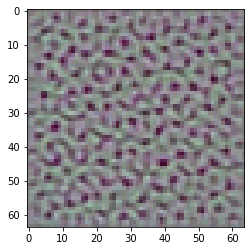

In [95]:
filter_img = generate_pattern(layer_name, 1+ (1 * 8),size = size)
plt.imshow(filter_img)

### 5.4.3　可视化类激活的热力图

它有助于了解一张图像的哪一部分让卷积神经网络做出了最终的分类决策。这有助于对卷积神经网络的决策过程进行调试，特别是出现分类错误的情况下。这种方法还可以定位图像中的特定目标。

这种通用的技术叫作类激活图（CAM，class activation  map）可视化，它是指对输入图像生成类激活的热力图。类激活热力图是与特定输出类别相关的二维分数网格，对任何输入图像的每个位置都要进行计算，它表示每个位置对该类别的重要程度。举例来说，对于输入到猫狗分类卷积神经网络的一张图像，CAM可视化可以生成类别“猫”的热力图，表示图像的各个部分与“猫”的相似程度，CAM可视化也会生成类别“狗”的热力图，表示图像的各个部分与“狗”的相似程度.   

我们将使用的具体实现方式是“Grad-CAM: visual explanations from deep networks via gradient-based localization ”这篇论文中描述的方法。这种方法非常简单：给定一张输入图像，对于一个卷积层的输出特征图，用类别相对于通道的梯度对这个特征图中的每个通道进行加权。直观上来看，理解这个技巧的一种方法是，你是用“每个通道对类别的重要程度”对“输入图像对不同通道的激活强度”的空间图进行加权，从而得到了“输入图像对类别的激活强度”的空间图。

我们再次使用预训练的 VGG16网络来演示此方法。

In [33]:
# 加载带有预训练权重的 VGG16网络

model= VGG16(weights= 'imagenet')


我们将这张图像转换为 VGG16模型能够读取的格式：模型在大小为224×224的图像上进行训练，这些训练图像都根据  keras.applications.vgg16.preprocess_input函数中内置的规则进行预处理。因此，我们需要加载图像，将其大小调整为      224×224，然后将其转换为float32格式的   Numpy张量，并应用这些预处理规则。

In [34]:
img_path='cats_and_dogs_small/test/cats/cat.1700.jpg'

img= image.load_img(img_path, target_size=(224,224))

x=image.img_to_array(img) # 转换成(224,224,3)的float32的Numpy数组

x=np.expand_dims(x,axis=0) # 添加一个维度， 将数组转换成 (1,224,224,3)

x=preprocess_input(x) # 对批量进行预处理。



现在你可以在图像上运行预训练的 VGG16网络，并将其预测向量解码为人类可读的格式。

In [35]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

/Users/yihuawang/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Predicted: [('n02124075', 'Egyptian_cat', 0.5240597), ('n02119789', 'kit_fox', 0.17562307), ('n02120505', 'grey_fox', 0.062272068)]


对这张图像预测的前三个类别分别为：   

埃及猫（Egyptian_cat，52.3%的概率）   
北美狐狸（kit_fox，17.6%的概率）   
灰色狐狸（grey_fox，6.2%的概率）   

网络识别出图像中包含数量不确定的埃及猫。预测向量中被最大激活的元素是对应“埃及猫”类别的元素，索引编号为 285。

In [36]:
np.argmax(preds[0])

285

In [37]:
Egyptian_cat_output = model.output[:,285]

last_conv_layer= model.get_layer('block5_conv3')

grads= K.gradients(Egyptian_cat_output,last_conv_layer.output)[0]

pooled_grads =K.mean(grads, axis=(0,1,2))

iterate=K.function([model.input],
                  [pooled_grads,last_conv_layer.output[0]])


pooled_grads_value, conv_layer_output_value= iterate([x])

for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap= np.mean(conv_layer_output_value,axis=-1)
    
    
    

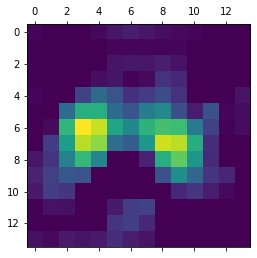

In [38]:
# 我们还需要将热力图标准化到 0~1范围内。
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

我们可以用 OpenCV来生成一张图像，将原始图像叠加在刚刚得到的热力图上

In [42]:
import cv2

img= cv2.imread(img_path) # 用cv2 加载原始图像

heatmap=cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap=np.uint8(225 * heatmap)

heatmap= cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)

superimposed_img= heatmap * 0.4 +img

cv2.imwrite('/Users/yihuawang/Deeplearning/Egyptian_cat.jpg',superimposed_img)

True

IndexError: tuple index out of range

这种可视化方法回答了两个重要问题：

网络为什么会认为这张图像中包含一头非洲象？    

非洲象在图像中的什么位置？

### 小结
1. 卷积神经网络是解决视觉分类问题的最佳工具。  
2. 卷积神经网络通过学习模块化模式和概念的层次结构来表示视觉世界。   
3. 卷积神经网络学到的表示很容易可视化，卷积神经网络不是黑盒。   
4. 现在你能够从头开始训练自己的卷积神经网络来解决图像分类问题。   
5. 你知道了如何使用视觉数据增强来防止过拟合。   
6. 你知道了如何使用预训练的卷积神经网络进行特征提取与模型微调。  
7. 你可以将卷积神经网络学到的过滤器可视化，也可以将类激活热力图可视化。   

Predicted: [('n03866082', 'overskirt', 0.28688332), ('n03534580', 'hoopskirt', 0.18672894), ('n03450230', 'gown', 0.10271115)]
689


True

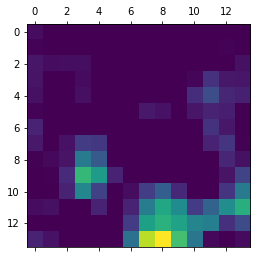

In [50]:
# Hu

img_path='Hu.JPG'

img= image.load_img(img_path, target_size=(224,224))

x=image.img_to_array(img) # 转换成(224,224,3)的float32的Numpy数组

x=np.expand_dims(x,axis=0) # 添加一个维度， 将数组转换成 (1,224,224,3)

x=preprocess_input(x) # 对批量进行预处理。

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])
print(np.argmax(preds[0]))

Egyptian_cat_output = model.output[:,np.argmax(preds[0])]

last_conv_layer= model.get_layer('block5_conv3')

grads= K.gradients(Egyptian_cat_output,last_conv_layer.output)[0]

pooled_grads =K.mean(grads, axis=(0,1,2))

iterate=K.function([model.input],
                  [pooled_grads,last_conv_layer.output[0]])


pooled_grads_value, conv_layer_output_value= iterate([x])

for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap= np.mean(conv_layer_output_value,axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

img= cv2.imread(img_path) # 用cv2 加载原始图像

heatmap=cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap=np.uint8(225 * heatmap)

heatmap= cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)

superimposed_img= heatmap * 0.4 +img

cv2.imwrite('/Users/yihuawang/Deeplearning/Hu_heatmap.jpg',superimposed_img)

Predicted: [('n04584207', 'wig', 0.04662359), ('n04590129', 'window_shade', 0.037573885), ('n02786058', 'Band_Aid', 0.03521455)]
903


True

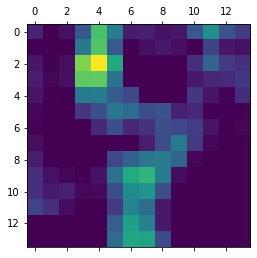

In [51]:

img_path='Zhou.JPG'

img= image.load_img(img_path, target_size=(224,224))

x=image.img_to_array(img) # 转换成(224,224,3)的float32的Numpy数组

x=np.expand_dims(x,axis=0) # 添加一个维度， 将数组转换成 (1,224,224,3)

x=preprocess_input(x) # 对批量进行预处理。

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])
print(np.argmax(preds[0]))

Egyptian_cat_output = model.output[:,np.argmax(preds[0])]

last_conv_layer= model.get_layer('block5_conv3')

grads= K.gradients(Egyptian_cat_output,last_conv_layer.output)[0]

pooled_grads =K.mean(grads, axis=(0,1,2))

iterate=K.function([model.input],
                  [pooled_grads,last_conv_layer.output[0]])


pooled_grads_value, conv_layer_output_value= iterate([x])

for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap= np.mean(conv_layer_output_value,axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

img= cv2.imread(img_path) # 用cv2 加载原始图像

heatmap=cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap=np.uint8(225 * heatmap)

heatmap= cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)

superimposed_img= heatmap * 0.4 +img

cv2.imwrite('/Users/yihuawang/Deeplearning/Zhou_heatmap.jpg',superimposed_img)

Predicted: [('n02123045', 'tabby', 0.13276358), ('n02112137', 'chow', 0.105215706), ('n02111277', 'Newfoundland', 0.075867414)]
281


True

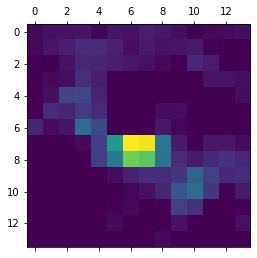

In [52]:
img_path='Angery Cat.jpg'

img= image.load_img(img_path, target_size=(224,224))

x=image.img_to_array(img) # 转换成(224,224,3)的float32的Numpy数组

x=np.expand_dims(x,axis=0) # 添加一个维度， 将数组转换成 (1,224,224,3)

x=preprocess_input(x) # 对批量进行预处理。

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])
print(np.argmax(preds[0]))

Egyptian_cat_output = model.output[:,np.argmax(preds[0])]

last_conv_layer= model.get_layer('block5_conv3')

grads= K.gradients(Egyptian_cat_output,last_conv_layer.output)[0]

pooled_grads =K.mean(grads, axis=(0,1,2))

iterate=K.function([model.input],
                  [pooled_grads,last_conv_layer.output[0]])


pooled_grads_value, conv_layer_output_value= iterate([x])

for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap= np.mean(conv_layer_output_value,axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

img= cv2.imread(img_path) # 用cv2 加载原始图像

heatmap=cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap=np.uint8(225 * heatmap)

heatmap= cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)

superimposed_img= heatmap * 0.4 +img

cv2.imwrite('/Users/yihuawang/Deeplearning/AngeryCat_heatmap.jpg',superimposed_img)

Predicted: [('n02865351', 'bolo_tie', 0.26604295), ('n04254120', 'soap_dispenser', 0.12686493), ('n04579145', 'whiskey_jug', 0.07747728)]
451


True

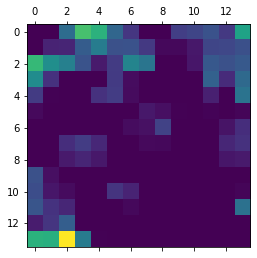

In [59]:
img_path='Dog.JPG'

img= image.load_img(img_path, target_size=(224,224))

x=image.img_to_array(img) # 转换成(224,224,3)的float32的Numpy数组

x=np.expand_dims(x,axis=0) # 添加一个维度， 将数组转换成 (1,224,224,3)

x=preprocess_input(x) # 对批量进行预处理。

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])
print(np.argmax(preds[0]))

Egyptian_cat_output = model.output[:,np.argmax(preds[0])]

last_conv_layer= model.get_layer('block5_conv3')

grads= K.gradients(Egyptian_cat_output,last_conv_layer.output)[0]

pooled_grads =K.mean(grads, axis=(0,1,2))

iterate=K.function([model.input],
                  [pooled_grads,last_conv_layer.output[0]])


pooled_grads_value, conv_layer_output_value= iterate([x])

for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap= np.mean(conv_layer_output_value,axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

img= cv2.imread(img_path) # 用cv2 加载原始图像

heatmap=cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap=np.uint8(225 * heatmap)

heatmap= cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)

superimposed_img= heatmap * 0.4 +img

cv2.imwrite('/Users/yihuawang/Deeplearning/Dog_meme_heatmap.jpg',superimposed_img)